In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Core python modules
import sys, os
import dill
from functools import partial

# Data processing
import pandas as pd
import numpy as np
import scipy

# Networks
import networkx as nx

# Modules
sys.path.insert(0, '../scripts')
from evaluation import Data
from samplers import *
from gsd import GSD
from benchmarks import *

In [3]:
# Plotting
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

# 0. Import data

## 0.1 iRefIndex v14 interactome

In [4]:
edgelist = pd.read_csv('../data/string.v10.5.cleaned.namespace-mapped.exp.tsv', sep='\t')
edgelist = edgelist[edgelist['protein1'] != edgelist['protein2']]
edgelist['cost'] = 1 / edgelist['confidence']
edgelist.head()

,protein1,protein2,confidence,cost
0,A1BG,CRISP3,0.457,2.188184
1,A1CF,CAVIN2,0.280,3.571429
2,A2M,ADAM19,0.382,2.617801
3,A2M,ADAMTS1,0.415,2.409639
4,A2M,ADAMTS12,0.315,3.174603


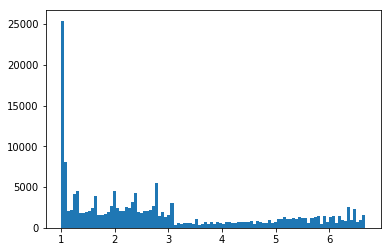

In [5]:
plt.hist(edgelist['cost'], bins=100);

In [6]:
G = nx.from_pandas_edgelist(edgelist, source='protein1', target='protein2', edge_attr=['confidence', 'cost'])
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 15077
Number of edges: 176203
Average degree:  23.3737


# 1. Parameter grid - Data matrices

In [64]:
eval_params = {
    'n_samples': [20,100,500], 
    'n_sources': [10], 
    'noise': [0,0.2,0.4,0.6,0.8,1.0],
    'rep': [1,2,3]
}

sampler = partial(sample_random_walk_fixed_size, graph=G, size=500)

data = Data(sampler, eval_params)

11:55:22 - Data: INFO - 54 parameter sets loaded.
11:55:22 - Data: INFO - 54 parameter sets loaded.


In [65]:
params = data.paramlist[0]
params

{'n_samples': 20, 'n_sources': 10, 'noise': 0, 'rep': 1}

In [66]:
X = data.get_data(**params)
X.shape

(20, 15077)

# 2. Decomposition

## GSD

In [91]:
def run_GSD(X, n_iterations, **params): 
    
    gsd = GSD(X, **params)
    
    for _ in range(n_iterations): 
        for i in range(gsd.n_components): 
            gsd.update(i)
            
    return gsd.components

In [92]:
gsd_params = {
    'graph': G, 
    'a': 0.1, 
    'n_components': 10, 
    'n_iterations': 5, 
    'initializer': 'ica'
}

In [93]:
tmp = partial(run_GSD, **gsd_params)

In [95]:
results_gsd, scores_gsd = data.evaluate(partial(run_GSD, **gsd_params))


12:01:11 - GSD: INFO - Initialized components and scores via ICA.
12:01:12 - GSD: INFO - Initialized components and scores via ICA.
12:01:13 - GSD: INFO - Initialized components and scores via ICA.
12:01:14 - GSD: INFO - Initialized components and scores via ICA.
12:01:15 - GSD: INFO - Initialized components and scores via ICA.
12:01:17 - GSD: INFO - Initialized components and scores via ICA.
12:01:17 - GSD: INFO - Initialized components and scores via ICA.
12:01:19 - GSD: INFO - Initialized components and scores via ICA.
12:01:21 - GSD: INFO - Initialized components and scores via ICA.
12:01:24 - GSD: INFO - Initialized components and scores via ICA.
12:01:52 - GSD: INFO - Initialized components and scores via ICA.
12:01:58 - GSD: INFO - Initialized components and scores via ICA.
12:02:01 - GSD: INFO - Initialized components and scores via ICA.
12:02:03 - GSD: INFO - Initialized components and scores via ICA.
12:02:09 - GSD: INFO - Initialized components and scores via ICA.
12:02:11 -

ValueError: Must pass 2-d input

In [97]:
data.summarize_scores(scores_gsd)

F1rr            recovery           relevance  \
                               mean       std      mean       std      mean   
n_samples n_sources noise                                                     
20        10        0.0    0.969329  0.006954  0.969329  0.006954  0.969329   
                    0.2    0.395358  0.139892  0.427985  0.117382  0.370296   
                    0.4    0.232395  0.041513  0.247752  0.037620  0.219137   
                    0.6    0.177235  0.011200  0.184104  0.011146  0.171041   
                    0.8    0.155804  0.001955  0.164155  0.001154  0.148284   
                    1.0    0.138293  0.008328  0.144011  0.006208  0.133059   
100       10        0.0    0.933195  0.066801  0.941841  0.051835  0.925043   
                    0.2    0.922358  0.007173  0.922358  0.007173  0.922358   
                    0.4    0.849464  0.006074  0.849464  0.006074  0.849464   
                    0.6    0.772745  0.006270  0.772745  0.006270  0.772745   
                    0.8    0.668610  0.027453  0.668940  0.026920  0.668282   
                    1.0    0.459847  0.146556  0.466398  0.140625  0.453642   
500       10        0.0    0.972874  0.001912  0.972874  0.001912  0.972874   
                    0.2    0.963891  0.003024  0.963891  0.003024  0.963891   
                    0.4    0.959736  0.002081  0.959736  0.002081  0.959736   
                    0.6    0.954464  0.005368  0.954464  0.005368  0.954464   
                    0.8    0.948536  0.004746  0.948536  0.004746  0.948536   
                    1.0    0.933495  0.007515  0.933495  0.007515  0.933495   

                                     
                                std  
n_samples n_sources noise            
20        10        0.0    0.006954  
                    0.2    0.152590  
                    0.4    0.044858  
                    0.6    0.013031  
                    0.8    0.003260  
                    1.0    0.010163  
100       10        0.0    0.080915  
                    0.2    0.007173  
                    0.4    0.006074  
                    0.6    0.006270  
                    0.8    0.027985  
                    1.0    0.152161  
500       10        0.0    0.001912  
                    0.2    0.003024  
                    0.4    0.002081  
                    0.6    0.005368  
                    0.8    0.004746  
                    1.0    0.007515

In [ ]:
    gsd = GSD(X, **params)
    
    for _ in range(n_iterations): 
        for i in range(gsd.n_components): 
            gsd.update(i)

## ICA

In [98]:
ica_params = {
    'cutoff': 0.01, 
    'n_components': 10
}

In [99]:
results_ica, scores_ica = data.evaluate(partial(ICA1, **ica_params))
data.summarize_scores(scores_ica)

/nfs/latdata/iamjli/projects/GSD/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/nfs/latdata/iamjli/projects/GSD/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/nfs/latdata/iamjli/projects/GSD/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/nfs/latdata/iamjli/projects/GSD/venv/lib/python3.6/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/nfs/latdata/iamjli/projects/GSD/venv/li

F1rr            recovery           relevance  \
                               mean       std      mean       std      mean   
n_samples n_sources noise                                                     
20        10        0.0    1.000000  0.000000  1.000000  0.000000  1.000000   
                    0.2    0.345860  0.083731  0.365723  0.073394  0.328811   
                    0.4    0.131370  0.015404  0.194516  0.004566  0.099873   
                    0.6    0.085744  0.002114  0.192220  0.006693  0.055181   
                    0.8    0.077131  0.001177  0.187867  0.006555  0.048551   
                    1.0    0.072238  0.004163  0.185140  0.007603  0.044924   
100       10        0.0    0.967837  0.055708  0.968313  0.054884  0.967363   
                    0.2    0.985745  0.004157  0.985745  0.004157  0.985745   
                    0.4    0.851251  0.011088  0.851251  0.011088  0.851251   
                    0.6    0.691545  0.016986  0.691545  0.016986  0.691545   
                    0.8    0.552977  0.009962  0.552977  0.009962  0.552977   
                    1.0    0.363320  0.093743  0.369703  0.087837  0.357341   
500       10        0.0    1.000000  0.000000  1.000000  0.000000  1.000000   
                    0.2    1.000000  0.000000  1.000000  0.000000  1.000000   
                    0.4    0.967840  0.055703  0.967840  0.055703  0.967840   
                    0.6    0.999134  0.000502  0.999134  0.000502  0.999134   
                    0.8    0.996008  0.000690  0.996008  0.000690  0.996008   
                    1.0    0.986332  0.001219  0.986332  0.001219  0.986332   

                                     
                                std  
n_samples n_sources noise            
20        10        0.0    0.000000  
                    0.2    0.090981  
                    0.4    0.017630  
                    0.6    0.001240  
                    0.8    0.001306  
                    1.0    0.003326  
100       10        0.0    0.056529  
                    0.2    0.004157  
                    0.4    0.011088  
                    0.6    0.016986  
                    0.8    0.009962  
                    1.0    0.099252  
500       10        0.0    0.000000  
                    0.2    0.000000  
                    0.4    0.055703  
                    0.6    0.000502  
                    0.8    0.000690  
                    1.0    0.001219

# Save and load evaluation set

In [18]:
dill.dump(E, open('test.pkl', 'wb'))

In [19]:
F = dill.load(open('test.pkl', 'rb'))